```
wget "https://challenge.blob.core.windows.net/challenge****files/****gear****_****images****.zip" -OutFile gear****_****images.zip
```

(remove the `****`), did this so that Google don't index this when people search for solutions

In [137]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [47]:
def resizeImageToSquare(image, desiredSize):
    # old_size[0] is in (width, height) format
    oldSize = image.size

    ratio = float(desiredSize)/max(oldSize)
    newSize = tuple([int(x*ratio) for x in oldSize])

    # use thumbnail() or resize() method to resize the input image
    # thumbnail is a in-place operation
    # im.thumbnail(new_size, Image.ANTIALIAS)
    image = image.resize(newSize, Image.ANTIALIAS)
    # create a new image and paste the resized on it
    resized = Image.new("RGB", (desiredSize, desiredSize),0xffffff)
    resized.paste(image, ((desiredSize-newSize[0])//2,
                        (desiredSize-newSize[1])//2))
    return resized

In [364]:
from pipe import Pipe

@Pipe
def as_npy(iterable):
    return np.array(iterable)

from functools import reduce
import operator
from pipe import select,take,as_list
from sklearn import tree
from glob import glob
from PIL import Image
import numpy as np
import re

def getImageTypeFromPath(imagePath):
    return re.search('[^\w](\w+)[^\w]', imagePath)[1]

# note I have obfuscated the names so that people can not google the solutions
imageTypes = {
    'ax**es': 0, 
    'bo**ots': 1, 
    'car**abiners': 2,
    'cr**ampons': 3, 
    'gl**oves': 4, 
    'hards**hell_jackets': 5, 
    'harne**sses': 6, 
    'hel**mets': 7, 
    'insula**ted_jackets': 8, 
    'pul**leys': 9, 
    'ro**pe': 10, 
    'ten**ts': 11, 
}

xy = glob("gear_images/**/*")  \
    | select(lambda path: (imageTypes[getImageTypeFromPath(path)], Image.open(path)))     \
    | select(lambda t: (t[0], resizeImageToSquare(t[1], 128)) )     \
    | select(lambda t: (t[0], np.array(t[1])))     \
    | select(lambda t: (t[0], t[1] / 255))     \
    | as_list()

X = xy | select(lambda e: e[1]) | as_list() | as_npy()

# flattened version for classical learning
Xf = X.reshape( X.shape[0], reduce(operator.mul, X.shape[1:], 1)  )
y = xy | select(lambda e: e[0]) | as_list() | as_npy()   

In [328]:
@Pipe
def pcycle(iterable):
    while True:
        for it in iterable:
            yield it
    
@Pipe        
def interleave(iterables):
    for it in iterables:
        yield next( it )

In [366]:
from pipe import chain, as_dict

def balancedSignalGenerator(X,y):
    return range(12) \
        | pcycle \
        | select( lambda c: list(np.where( y==c )[0]) | select( lambda i: (c,X[i]) ) | pcycle ) \
        | interleave
    

In [371]:
data_flat = balancedSignalGenerator(Xf,y) | take(1000) | as_list
data = balancedSignalGenerator(X,y) | take(1000) | as_list

In [372]:
Xbal_flat = data_flat | select( lambda d: d[1] ) | as_list | as_npy
Xbal = data | select( lambda d: d[1] ) | as_list | as_npy
ybal = data | select( lambda d: d[0] ) | as_list | as_npy

(array([84., 84., 84., 84., 83., 83., 83., 83., 83., 83., 83., 83.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <a list of 12 Patch objects>)

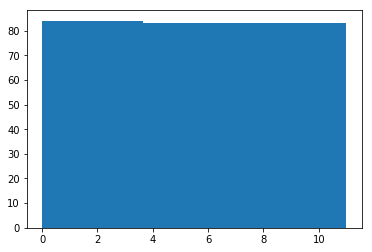

In [373]:
plt.hist(ybal, bins=12)

In [398]:
from sklearn.model_selection import train_test_split

Xtrain_flat, Xtest_flat, Ytrain, Ytest = train_test_split(Xbal_flat, ybal, test_size = 0.90, random_state = 0)

In [399]:
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(Xtrain_flat, Ytrain)

In [400]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

preds = classifier.predict(Xtest_flat)

print( confusion_matrix(Ytest, preds) )
print(f1_score(Ytest, preds, average='macro') )

[[72  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 77  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 82  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 73  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 76  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 76  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 74  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 76  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 79  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 73  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 74  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 68]]
1.0


In [72]:

import random
@Pipe
def pshuffle(l):
    random.shuffle(l)
    return l

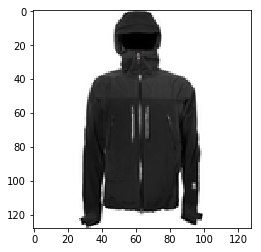

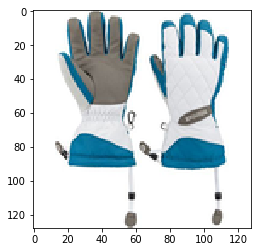

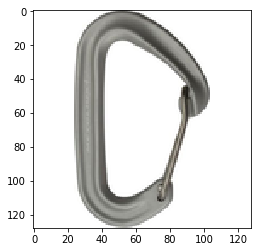

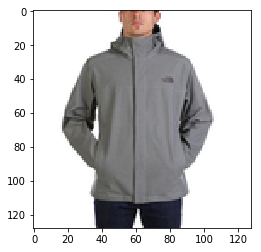

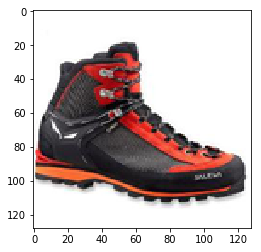

In [76]:
from pipe import take, select

test_images = range( Xtest.shape[0] ) | as_list() | pshuffle() | take(5) | select( lambda i: Xtrain[i] ) | as_list()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for img in test_images:

    plt.imshow(img)
    plt.show()

In [80]:
from random import uniform

X_test_whitenoise = Xtest

mask = X_test_whitenoise>0.9
vals = range(np.count_nonzero(mask)) | select( lambda n: uniform(0, 1)) | as_list()

# Assign back into X
X_test_whitenoise[mask] = vals

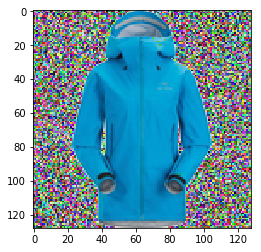

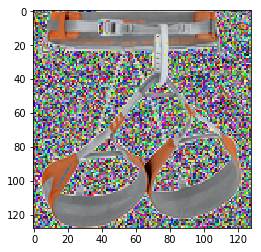

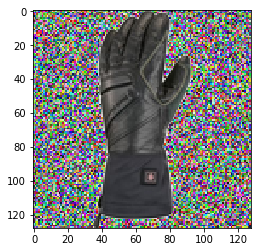

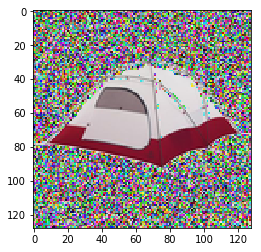

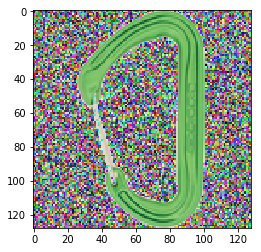

In [81]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pipe import take, select

noisy_images = range( X_test_whitenoise.shape[0] )     \
    | as_list()     \
    | pshuffle()     \
    | take(5)     \
    | select( lambda i: X_test_whitenoise[i] )     \
    | as_list()

for img in noisy_images:

    plt.imshow(img)
    plt.show()

In [106]:
bwx_train = np.mean( Xtrain, axis=3 )
whites_train = range(bwx_train.shape[0]) \
    | select( lambda i: np.count_nonzero(bwx_train[i]>0.99) ) \
    | as_list() \
    | as_npy

whites_train = whites_train.reshape(-1, 1)

bwx_test = np.mean( Xtest, axis=3 )
whites_test = range(bwx_test.shape[0]) \
    | select( lambda i: np.count_nonzero(bwx_test[i]>0.99) ) \
    | as_list() \
    | as_npy

whites_test = whites_test.reshape(-1, 1)

In [128]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(whites_train)

whites_train_01 = scaler.transform(whites_train)
whites_test_01 = scaler.transform(whites_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [141]:
from keras.utils import to_categorical

Ytest_onehot = to_categorical(Ytest)
Ytrain_onehot = to_categorical(Ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [142]:
Ytest_onehot.shape

(531, 12)

In [154]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([
    Dense(32, input_shape=(1,)),
    Activation('relu'),
    Dense(12),
    Activation('softmax'),
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    whites_train_01, 
    Ytrain_onehot, 
    validation_data=(whites_test_01, Ytest_onehot), 
    epochs=12, 
    batch_size=32)



Train on 1591 samples, validate on 531 samples
Epoch 1/12
1591/1591 [==============================] - 0s 246us/step - loss: 2.4560 - acc: 0.1747 - val_loss: 2.4500 - val_acc: 0.2166
Epoch 2/12
1591/1591 [==============================] - 0s 35us/step - loss: 2.4032 - acc: 0.2162 - val_loss: 2.4208 - val_acc: 0.2166
Epoch 3/12
1591/1591 [==============================] - 0s 35us/step - loss: 2.3680 - acc: 0.2162 - val_loss: 2.3960 - val_acc: 0.2166
Epoch 4/12
1591/1591 [==============================] - 0s 35us/step - loss: 2.3458 - acc: 0.2162 - val_loss: 2.3764 - val_acc: 0.2166
Epoch 5/12
1591/1591 [==============================] - 0s 33us/step - loss: 2.3319 - acc: 0.2162 - val_loss: 2.3650 - val_acc: 0.2166
Epoch 6/12
1591/1591 [==============================] - 0s 35us/step - loss: 2.3227 - acc: 0.2162 - val_loss: 2.3559 - val_acc: 0.2166
Epoch 7/12
1591/1591 [==============================] - 0s 35us/step - loss: 2.3142 - acc: 0.2162 - val_loss: 2.3506 - val_acc: 0.2166
Epoch 8

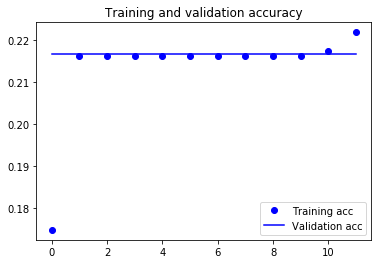

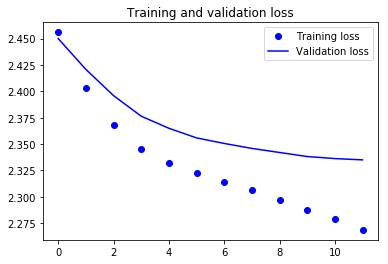

In [155]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [157]:
model.predict_classes( whites_test_01 )

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

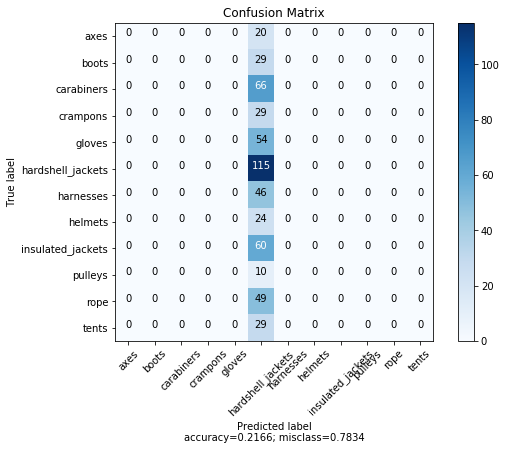

In [138]:
plot_confusion_matrix(confusion_matrix(Ytest, clf_preds), 
                      normalize    = False,
                      target_names = list(imageTypes),
                      title        = "Confusion Matrix")